In [1]:
import os
import numpy as np
import torch as T
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical

## Memory

In [2]:
class PPOMemory:
    def __init__(self,batch_size):
        self.states = []
        self.probs = []
        self.vals = []
        self.actions = []
        self.rewards = []
        self.dones = []

        self.batch_size = batch_size

    def generate_butches(self):

        return np.array(self.states), \
               np.array(self.actions), \
               np.array(self.probs), \
               np.array(self.vals), \
               np.array(self.rewards), \
               np.array(self.dones)
               # batches

    def store_memory(self, state, action, probs, vals, reward, done):
        self.states.append(state)
        self.probs.append(probs)
        self.vals.append(vals)
        self.rewards.append(reward)
        self.actions.append(action)
        self.dones.append(done)

    def clear_memory(self):
        self.states = []
        self.probs = []
        self.vals = []
        self.actions = []
        self.rewards = []
        self.dones = []

## Actor

In [3]:
class ActorNetwork(nn.Module):
    def __init__(self,n_actions, input_dims, alpha,
                 chkpt_dir='tmp/ppo'):
        super(ActorNetwork, self).__init__()

        self.checkpoint_file = os.path.join(chkpt_dir, 'actor_ppo')
        
        self.l1 = nn.Linear(*input_dims, 256)
        self.r1 = nn.ReLU()
        self.l2 = nn.Linear(256, 256)
        self.r2 = nn.ReLU()
        self.l3 = nn.Linear(256,n_actions)
        self.st = nn.Softmax(dim=-1)   

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self,state):
        x = self.r1(self.l1(state))
        x = self.r2(self.l2(x))
        x = self.st(self.l3(x))
        dist = Categorical(x)

        return dist

    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file))

## Critic

In [4]:
class CriticNetwork(nn.Module):
    def __init__(self, input_dims, alpha,  chkpt_dir='tmp/ppo'):
        super(CriticNetwork, self).__init__()

        self.checkpoint_file = os.path.join(chkpt_dir, 'critic_ppo')
        self.critic = nn.Sequential(
                nn.Linear(*input_dims, 256),
                nn.ReLU(),
                nn.Linear(256, 256),
                nn.ReLU(),
                nn.Linear(256,1),
                nn.Softmax(dim=-1)
        )

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self,state):
        value = self.critic(state)

        return value

    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file))

## Agent

In [5]:
class Agent:
    def __init__(self, n_actions, input_dims, gamma=0.99, alpha=0.003, gae_lambda=0.95,
                 policy_clip=0.2, batch_size=64, N=2048, n_epochs=10):
        self.gamma = gamma
        self.policy_clip = policy_clip
        self.n_epochs = n_epochs
        self.gae_lambda = gae_lambda

        self.actor = ActorNetwork(n_actions = n_actions, input_dims = input_dims, alpha = alpha)
        self.critic = CriticNetwork(input_dims, alpha = alpha)
        self.memory = PPOMemory(batch_size)

    def remember(self, state, action, probs, vals, reward, done):
        self.memory.store_memory(state, action, probs, vals, reward, done)

    def save_models(self):
        print('... saving models ...')
        self.actor.save_checkpoint()
        self.critic.save_checkpoint()

    def load_models(self):
        print('... loading models ...')
        self.actor.load_checkpoint()
        self.critic.load_checkpoint()

    def choose_action(self, observation):
        state = T.tensor([observation], dtype=T.float).to(self.actor.device)

        dist = self.actor(state)
        value = self.critic(state)
        action = dist.sample()

        probs = T.squeeze(dist.log_prob(action)).item()
        action = T.squeeze(action).item()
        value = T.squeeze(value).item()

        return action, probs, value

    def learn(self):
        for i in range(10):
            state_arr, action_arr, old_probs_arr, vals_arr, \
            reward_arr, done_arrs = self.memory.generate_butches()

            values = vals_arr
            advantage = np.zeros(len(reward_arr), dtype = np.float32)

            for t in range(len(reward_arr)-1):
                discount = 1
                a_t = 0
                for k in range(t, len(reward_arr)-1):
                    a_t += discount*(reward_arr[k] + self.gamma*values[k+1]* \
                                    (1-int(done_arrs[k])) - values[k])
                    discount *= self.gamma*self.gae_lambda
                advantage[t] = a_t
            advantage = T.tensor(advantage).to(self.actor.device)

            values = T.tensor(values).to(self.actor.device)
            states = T.tensor(state_arr, dtype=T.float).to(self.actor.device)
            old_probs = T.tensor(old_probs_arr).to(self.actor.device)
            actions = T.tensor(action_arr).to(self.actor.device)

            dist = self.actor(states)
            # print(dist)

            critic_value = self.critic(states)

            critic_value = T.squeeze(critic_value)

            new_probs = dist.log_prob(actions)
            # prob_ratio = new_probs.exp() / old_probs.exp()
            prob_ratio = (new_probs - old_probs).exp()
            weight_probs = advantage * prob_ratio
            weight_clipped_probs = T.clamp(prob_ratio, 1-self.policy_clip,
                    1+self.policy_clip)*advantage
            actor_loss = -T.min(weight_probs, weight_clipped_probs).mean()

            returns = advantage + values
            critic_loss = (returns-critic_value)**2
            critic_loss = critic_loss.mean()

            total_loss = actor_loss + 0.5*critic_loss
            self.actor.optimizer.zero_grad()
            self.critic.optimizer.zero_grad()
            total_loss.backward()
            self.actor.optimizer.step()
            self.critic.optimizer.step()

        self.memory.clear_memory()

## Main

In [6]:
import gym
import numpy
import numpy as np
from IPython.display import clear_output

In [7]:
env = gym.make('CartPole-v0')
N = 20
batch_size = 5
n_epochs = 4
alpha = 0.003
agent = Agent(n_actions=env.action_space.n, batch_size=batch_size,
              alpha=alpha, n_epochs=n_epochs,
              input_dims=env.observation_space.shape)

n_games = 1000

best_score = env.reward_range[0]
score_history = []

learn_iters = 0
avg_score = 0
n_steps = 0

for i in range(n_games):
    observation = env.reset()
    done = False
    score = 0
    while not done:
        action, prob, val = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        n_steps += 1
        score += reward
        agent.remember(observation, action, prob, val, reward, done)
        if n_steps % N == 0:
            agent.learn()
            learn_iters += 1
        observation = observation_
    score_history.append(score)
    avg_score = np.mean(score_history[-100:])

    if avg_score > best_score:
        best_score = avg_score
        agent.save_models()
    
    if not bool(i%10):clear_output()
    
    print('episode ', i, 'score %.1f' % score, 'avg score %.1f' % avg_score,
          'time step', n_steps, 'learning_steps', learn_iters)

episode  990 score 21.0 avg score 16.4 time step 15599 learning_steps 779
episode  991 score 18.0 avg score 16.4 time step 15617 learning_steps 780
episode  992 score 28.0 avg score 16.5 time step 15645 learning_steps 782
episode  993 score 18.0 avg score 16.5 time step 15663 learning_steps 783
episode  994 score 22.0 avg score 16.6 time step 15685 learning_steps 784
episode  995 score 15.0 avg score 16.6 time step 15700 learning_steps 785
episode  996 score 17.0 avg score 16.6 time step 15717 learning_steps 785
episode  997 score 21.0 avg score 16.7 time step 15738 learning_steps 786
episode  998 score 17.0 avg score 16.7 time step 15755 learning_steps 787
episode  999 score 18.0 avg score 16.8 time step 15773 learning_steps 788


In [8]:
import matplotlib.pyplot as plt

def plot_learning_curve(x, scores, filename, lines=None):
    fig=plt.figure()
    ax=fig.add_subplot(111, label="1")
    ax2=fig.add_subplot(111, label="2", frame_on=False)

    ax.set_xlabel("Num games", color="C0")
    ax.tick_params(axis='x', colors="C0")
    ax.tick_params(axis='y', colors="C0")

    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = np.mean(scores[max(0, t-20):(t+1)])

    ax2.scatter(x, running_avg, color="C1")
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    ax2.set_ylabel('Score', color="C1")
    ax2.yaxis.set_label_position('right')
    ax2.tick_params(axis='y', colors="C1")

    if lines is not None:
        for line in lines:
            plt.axvline(x=line)

    plt.savefig(filename)

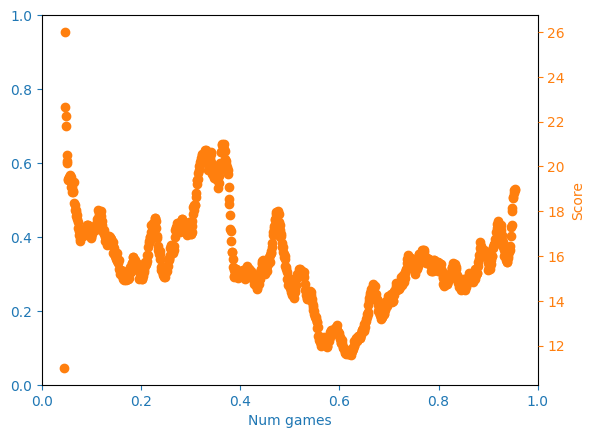

In [9]:
x = [i+1 for i in range(len(score_history))]
plot_learning_curve(x, score_history, filename = 'PPO.png')

In [10]:
# x